In [ ]:
!pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import os
import shutil
import random

random.seed(42)

# Original dataset directory
data_dir = "../PlantVillage-Dataset/raw/color"
train_dir = "../PlantVillage/train"
test_dir = "../PlantVillage/test"
split_ratio = 0.8  # 80% train, 20% test

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class folders
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = [img for img in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, img))]
    random.shuffle(images)

    # Calculate split index
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Move images
    for img in train_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("Dataset successfully split into training and testing sets.")


Dataset successfully split into training and testing sets.


Using device: cuda
Model loaded successfully from plantvillage_best_finetuned_byol_mim_contrastive_epoch85.pth.pth
Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_bl

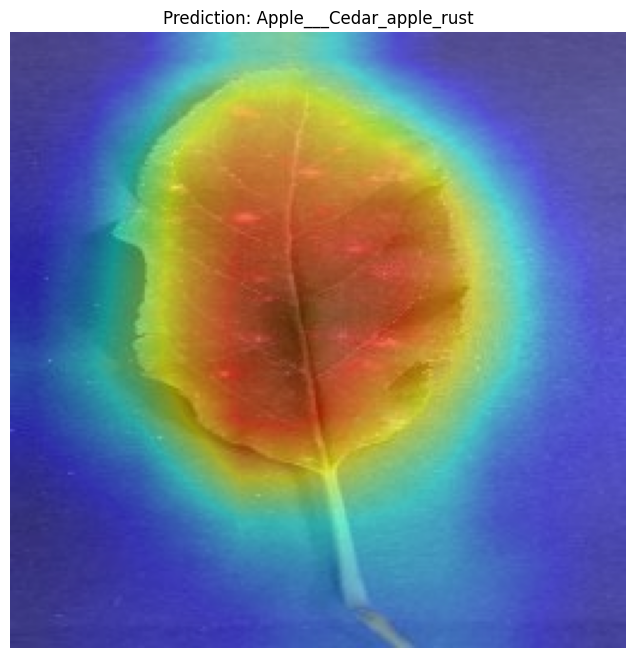

/tmp/ipykernel_174770/3361361490.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


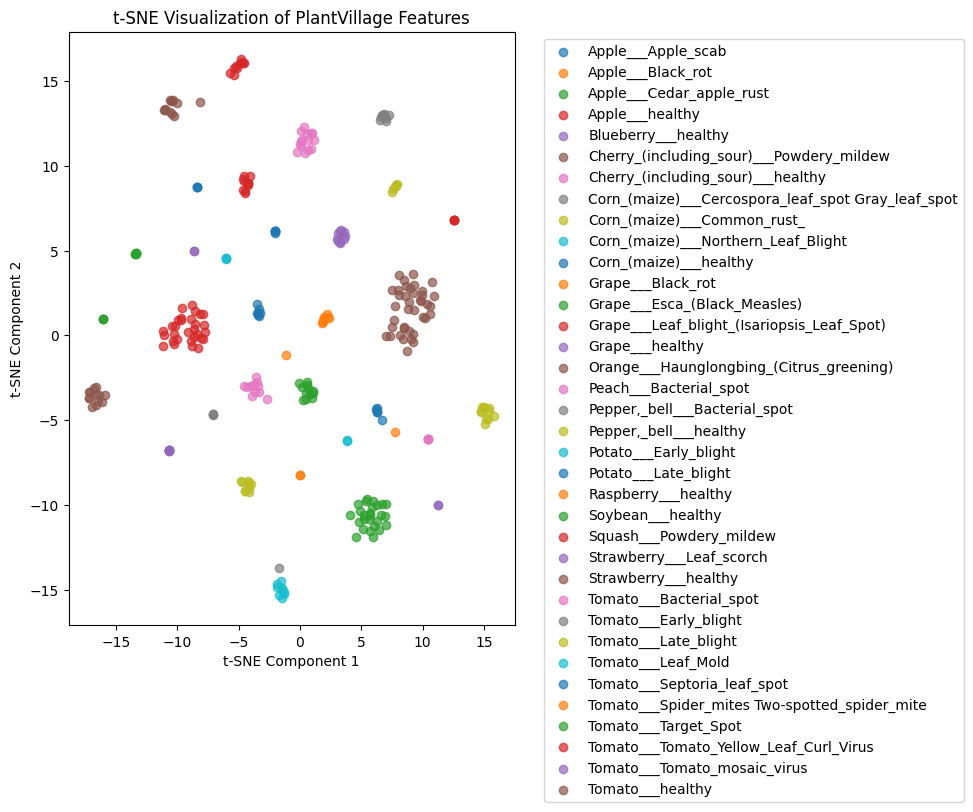

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.manifold import TSNE
import random
import os

# Ensure Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model Definition
class MLPClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Build model adjusted for PlantVillage (38 classes)
def build_model(num_classes=38):
    model = models.resnet101(weights=None)
    model.fc = MLPClassifier(in_features=2048, num_classes=num_classes)
    return model

# Update paths for PlantVillage
checkpoint_path = "plantvillage_best_finetuned_byol_mim_contrastive_epoch85.pth.pth"
num_classes = 38

model = build_model(num_classes=num_classes).to(device)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Model loaded successfully from", checkpoint_path)

# Data Directories
train_data_dir = "../PlantVillage/train"
test_data_dir = "../PlantVillage/test"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class names
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
class_names = train_dataset.classes
print("Class Names:", class_names)

# Grad-CAM visualization
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3))[0]
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy()

def overlay_heatmap(original_img, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (original_img.width, original_img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    original_np = np.array(original_img)
    overlay = cv2.addWeighted(original_np, 1 - alpha, heatmap, alpha, 0)
    return Image.fromarray(overlay)

# Example Grad-CAM usage
sample_image_path = "../PlantVillage/test/Apple___Cedar_apple_rust/bc863aa7-2cb6-44f1-b060-4cd78237d7a3___FREC_C.Rust 3566.JPG"
ground_truth_label = "Apple___Cedar_apple_rust"

if os.path.exists(sample_image_path):
    img = Image.open(sample_image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    target_layer = model.layer4[-1]
    gradcam = GradCAM(model, target_layer)
    cam = gradcam(input_tensor)
    gradcam.remove_hooks()

    overlayed_img = overlay_heatmap(img, cam)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlayed_img)
    plt.title(f"Prediction: {ground_truth_label}")
    plt.axis('off')
    plt.show()

# t-SNE visualization on PlantVillage
def tsne_visualization(sample_size=300, batch_size=16):
    dataset = ImageFolder(root=test_data_dir, transform=transform)
    indices = np.random.choice(len(dataset), size=sample_size, replace=False)
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

    feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
    feature_extractor.eval()

    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs).view(imgs.size(0), -1)
            features.append(feats.cpu().numpy())
            labels.extend(lbls.numpy())

    features = np.vstack(features)
    tsne_results = TSNE(n_components=2, random_state=42).fit_transform(features)

    plt.figure(figsize=(10, 8))
    cmap = plt.cm.get_cmap('tab20', num_classes)
    for i in np.unique(labels):
        plt.scatter(tsne_results[np.array(labels) == i, 0], tsne_results[np.array(labels) == i, 1],
                    label=class_names[i], alpha=0.7)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('t-SNE Visualization of PlantVillage Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    plt.show()

tsne_visualization()
